<a href="https://colab.research.google.com/github/Salabh2k2/Awesome-Project-Collection/blob/main/Traffic_flow_Prediction_using_LSTM%2BFasterSTGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Initial Basic Downloads
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import load
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

from keras.layers import LSTM, Dense, Dropout
from keras.metrics import RootMeanSquaredError
import scipy.stats as stats

In [ ]:
# For making better plotting
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5

Let's Do so me Data Visualization, as Ritual


In [ ]:
traffic = pd.read_csv("/content/traffic.csv")
print(len(traffic))
traffic.head()

841110


,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


In [ ]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841110 entries, 0 to 841109
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   timestep  841110 non-null  int64  
 1   location  841110 non-null  int64  
 2   flow      841109 non-null  float64
 3   occupy    841109 non-null  float64
 4   speed     841109 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 32.1 MB


In [ ]:
traffic.count()

,0
timestep,841110
location,841110
flow,841109
occupy,841109
speed,841109


In [ ]:
traffic.isna().sum()

,0
timestep,0
location,0
flow,1
occupy,1
speed,1


In [ ]:
traffic.describe()


,timestep,location,flow,occupy,speed
count,841110.000000,841110.000000,841109.000000,841109.00000,841109.000000
mean,2474.352962,84.496433,224.659258,0.06214,64.076202
std,1428.280518,49.073105,143.434521,0.04248,6.225248
min,1.000000,0.000000,0.000000,0.00000,3.000000
25%,1237.000000,42.000000,107.000000,0.03450,62.800000
50%,2474.000000,84.000000,207.000000,0.05800,65.000000
75%,3711.000000,127.000000,326.000000,0.08160,67.500000
max,4948.000000,169.000000,898.000000,0.74670,81.100000


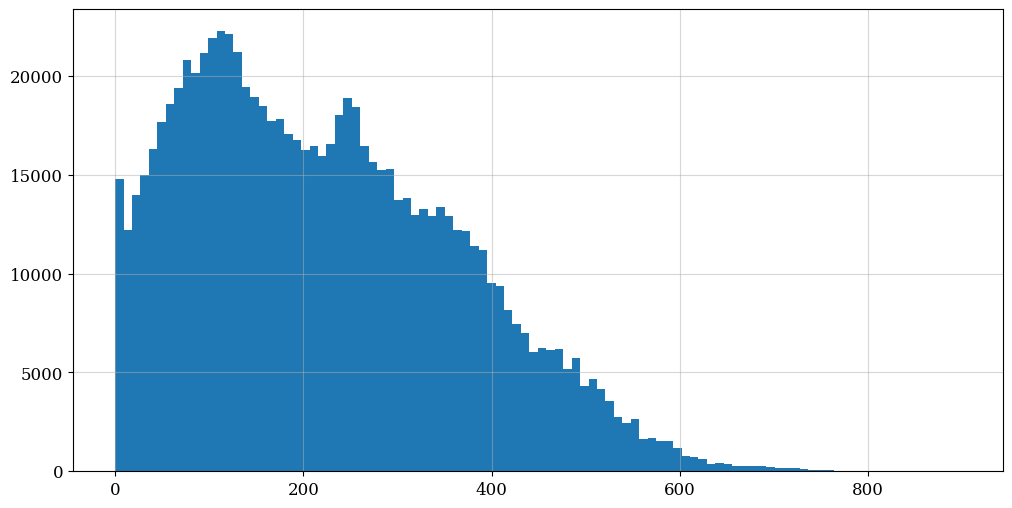

In [ ]:
traffic['flow'].hist(bins=100);

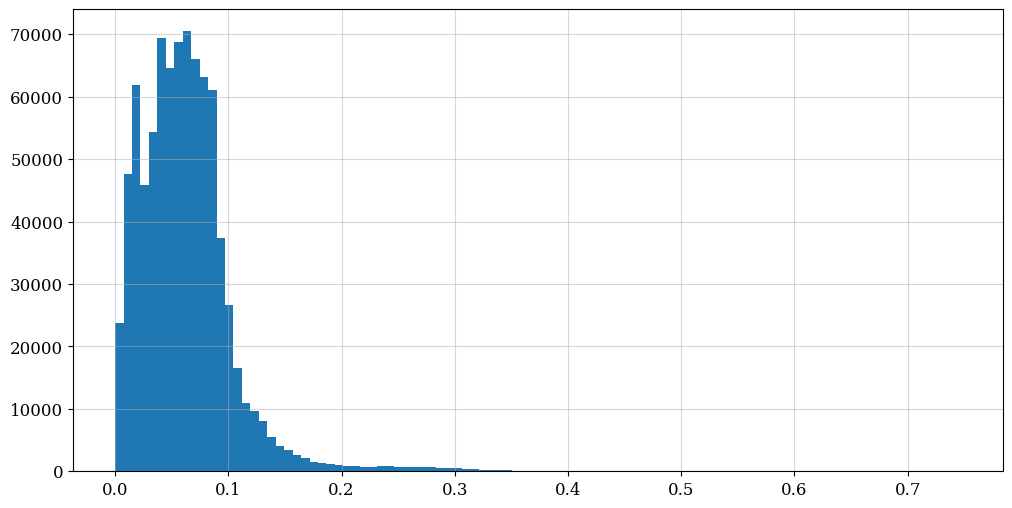

In [ ]:
traffic['occupy'].hist(bins=100);

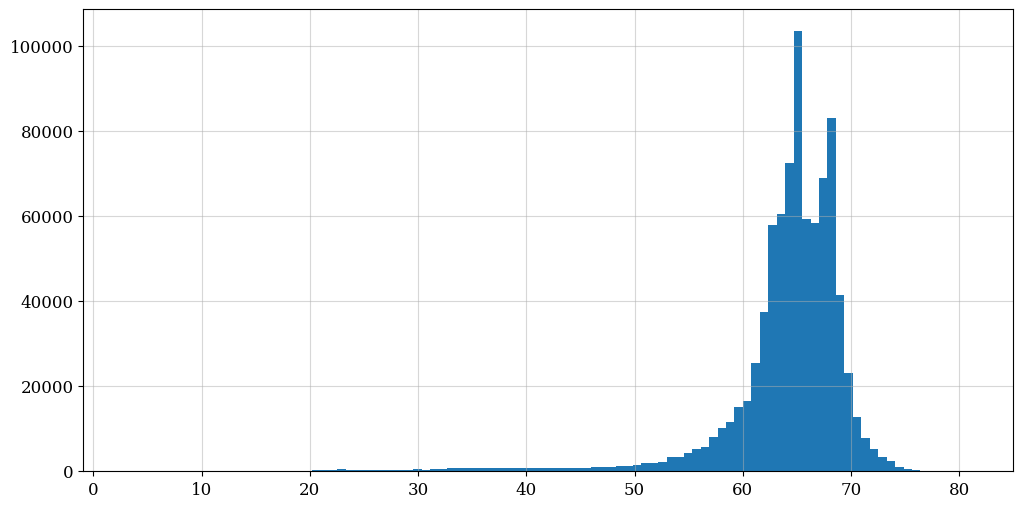

In [ ]:
traffic['speed'].hist(bins=100);

In [ ]:
location_0 = traffic[traffic["location"]==50].reset_index()
location_0.head()

,index,timestep,location,flow,occupy,speed
0,50,1,50,76.0,0.0262,69.5
1,220,2,50,81.0,0.0255,68.8
2,390,3,50,80.0,0.0243,69.0
3,560,4,50,76.0,0.0255,68.4
4,730,5,50,70.0,0.0224,68.1


<Axes: >

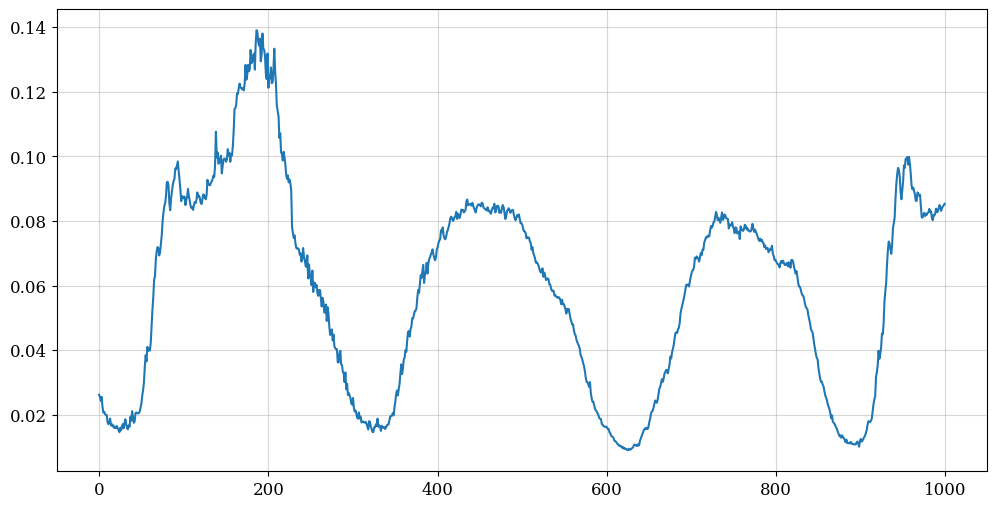

In [ ]:
location_0["occupy"][:1000].plot()

<Axes: >

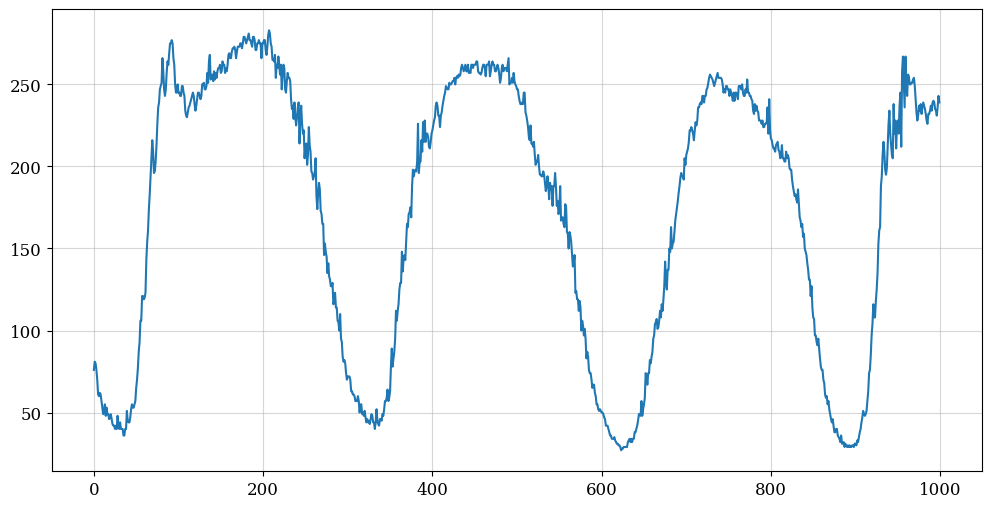

In [ ]:
location_0["flow"][:1000].plot()

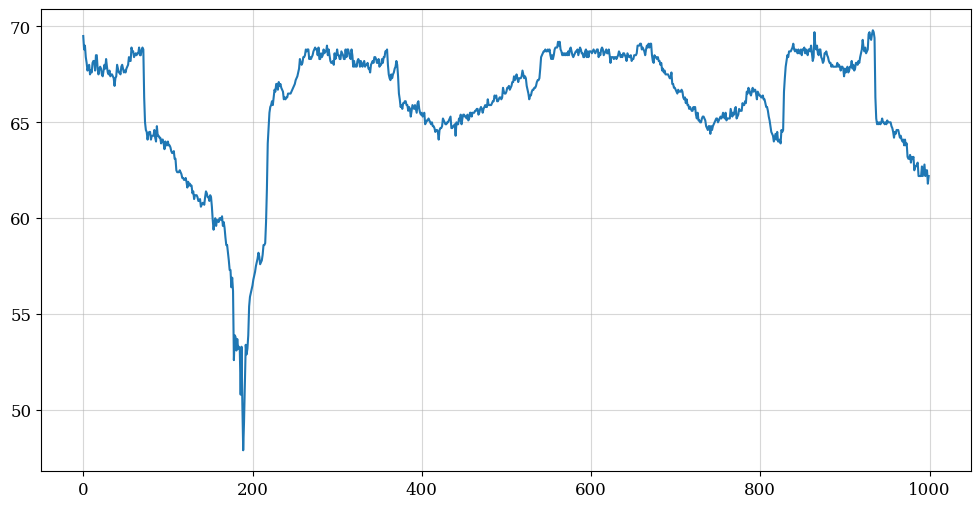

In [ ]:
location_0["speed"][:1000].plot();

We will use first Time Series Prediction which is K-lag. It is a good measure to check the correlation of present and future values

In [ ]:
COR_STEP = 1
pres = traffic[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = traffic[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.689189,-0.288343,0.536388,0.457151,-0.231809
occupy,0.689189,1.000000,-0.730555,0.457617,0.486943,-0.307194
speed,-0.288343,-0.730555,1.000000,-0.221308,-0.270558,0.242906
flow_future,0.536388,0.457617,-0.221308,1.000000,0.689189,-0.288342
occupy_future,0.457151,0.486943,-0.270558,0.689189,1.000000,-0.730555
speed_future,-0.231809,-0.307194,0.242906,-0.288342,-0.730555,1.000000


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

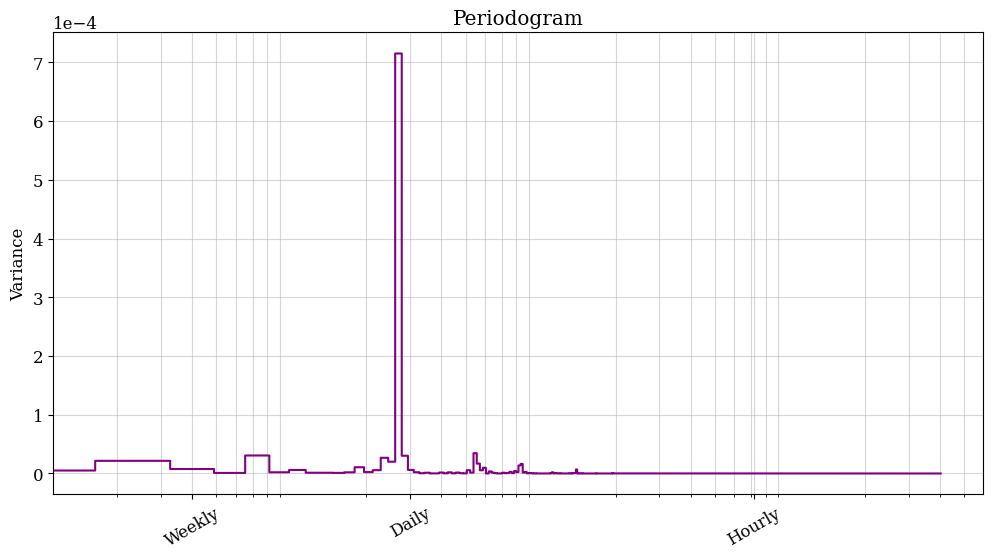

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Plots the periodogram of a time series.

    Args:
        ts (pd.Series): A time series.
        detrend (str): Detrending method for the time series.
        ax (matplotlib.axes.Axes): The axes on which to plot.

    Returns:
        ax (matplotlib.axes.Axes): The axes on which the periodogram is plotted.
    """
    fs = pd.Timedelta(weeks=4) / pd.Timedelta(minutes=5)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([4, 30, 30*24])
    ax.set_xticklabels(
        [
            "Weekly",
            "Daily",
            "Hourly"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(location_0["occupy"])

Since data is pretty even so we will basically divide the time in hour and work on timestamps of 5 min only due to MLE.

In [ ]:
location_0["hour"] = ((location_0["timestep"] - 1) // 12)
grouped = location_0.groupby("hour").mean().reset_index()
grouped.head()

,hour,index,timestep,location,flow,occupy,speed
0,0,985.0,6.5,50.0,65.500000,0.021700,68.191667
1,1,3025.0,18.5,50.0,48.166667,0.016567,67.900000
2,2,5065.0,30.5,50.0,41.166667,0.016350,67.691667
3,3,7105.0,42.5,50.0,46.666667,0.019350,67.591667
4,4,9145.0,54.5,50.0,89.750000,0.031800,68.141667


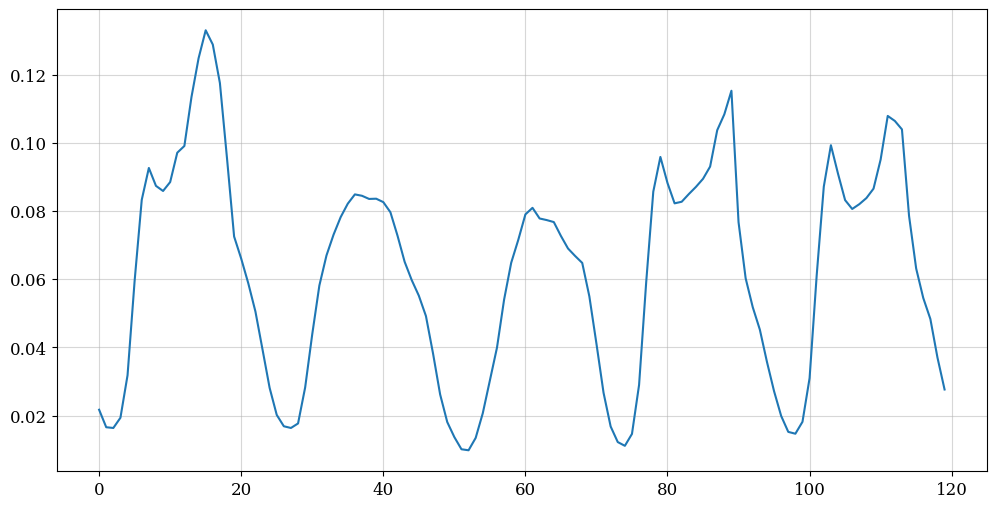

In [ ]:
grouped["occupy"][:24*5].plot();

In [ ]:
COR_STEP = 12
pres = grouped[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = grouped[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.964091,-0.709137,-0.727793,-0.713053,0.682758
occupy,0.964091,1.000000,-0.840567,-0.711216,-0.695049,0.658880
speed,-0.709137,-0.840567,1.000000,0.671577,0.653348,-0.557323
flow_future,-0.727793,-0.711216,0.671577,1.000000,0.963917,-0.707481
occupy_future,-0.713053,-0.695049,0.653348,0.963917,1.000000,-0.839811
speed_future,0.682758,0.658880,-0.557323,-0.707481,-0.839811,1.000000


So finally coorelation values are higher which means we can now prepare the data

In [ ]:
def create_dataset(location, WINDOW_SIZE):

    location_current = traffic[traffic["location"]==location].reset_index()
    location_current["hour"] = ((location_current["timestep"] - 1) // 12)
    grouped = location_current.groupby("hour").mean().reset_index()
    grouped['day'] = (grouped['hour'] // 24) % 7
    grouped['hour'] %= 24

    one_hot_hour = pd.get_dummies(grouped['hour'])
    one_hot_hour = one_hot_hour.add_prefix('hour_')
    hour_grouped = pd.concat([grouped[["occupy", "flow", "speed"]], one_hot_hour], axis=1)
    hour_grouped = np.array(hour_grouped)

    X, Y = [], []
    for i in range(len(hour_grouped) - WINDOW_SIZE):
        X.append(hour_grouped[i:(i + WINDOW_SIZE)][::-1])
        Y.append(hour_grouped[i + WINDOW_SIZE, 0])

    return X,Y

In [ ]:
X, Y = [], []

for location in range(170):
    a,b = create_dataset(location, WINDOW_SIZE=24)
    X.append(a)
    Y.append(b)

X = np.moveaxis(X,0,-1)
Y = np.moveaxis(Y,0,-1)

print(X.shape)
print(Y.shape)

(389, 24, 27, 170)
(389, 170)


In [ ]:
TRAIN_SIZE = 0.8
TEST_SIZE  = 0.2

train_size = int(len(X) * TRAIN_SIZE)
test_size  = int(len(X) * TEST_SIZE)

train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(311, 24, 27, 170)
(311, 170)
(78, 24, 27, 170)
(78, 170)


In [ ]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X.reshape(train_X.shape[0] * train_X.shape[1], -1)) \
                   .reshape(train_X.shape[0], train_X.shape[1], -1)
test_X = scaler_X.transform(test_X.reshape(test_X.shape[0] * test_X.shape[1], -1)) \
                   .reshape(test_X.shape[0], test_X.shape[1], -1)
train_Y = scaler_Y.fit_transform(train_Y)
test_Y = scaler_Y.transform(test_Y)

In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(311, 24, 4590)
(78, 24, 4590)
(311, 170)
(78, 170)


Here comes the MODEL

In [ ]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(170, activation='linear'),
])

model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 256)             │       4,963,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 170)                 │          43,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,598,122 (21.36 MB)

 Trainable params: 5,598,122 (21.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

!pip install keras.utils.vis_utils
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

ERROR: Could not find a version that satisfies the requirement keras.utils.vis_utils (from versions: none)
ERROR: No matching distribution found for keras.utils.vis_utils


ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [ ]:
history = model.fit(train_X, train_Y, epochs=150, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/150
9/9 - 12s - 1s/step - loss: 0.1054 - root_mean_squared_error: 0.3246 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2062
Epoch 2/150
9/9 - 11s - 1s/step - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1680
Epoch 3/150
9/9 - 9s - 964ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1354
Epoch 4/150
9/9 - 9s - 978ms/step - loss: 0.0251 - root_mean_squared_error: 0.1584 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 5/150
9/9 - 7s - 796ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 6/150
9/9 - 11s - 1s/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1384
Epoch 7/150
9/9 - 7s - 725ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 8/150
9/9 - 8s - 920

In [ ]:
def plot_training(training_history, text, width):
    history = training_history.history[text]

    moving_average = [float("NaN") for i in range(width)]
    for i in range(width, len(history)+1):
        moving_average.append(np.mean(np.array(history[i-width:i+1])))

    plt.plot(history)
    plt.plot(moving_average)
    plt.title(text)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['value','moving average'], loc='upper left')
    plt.show()

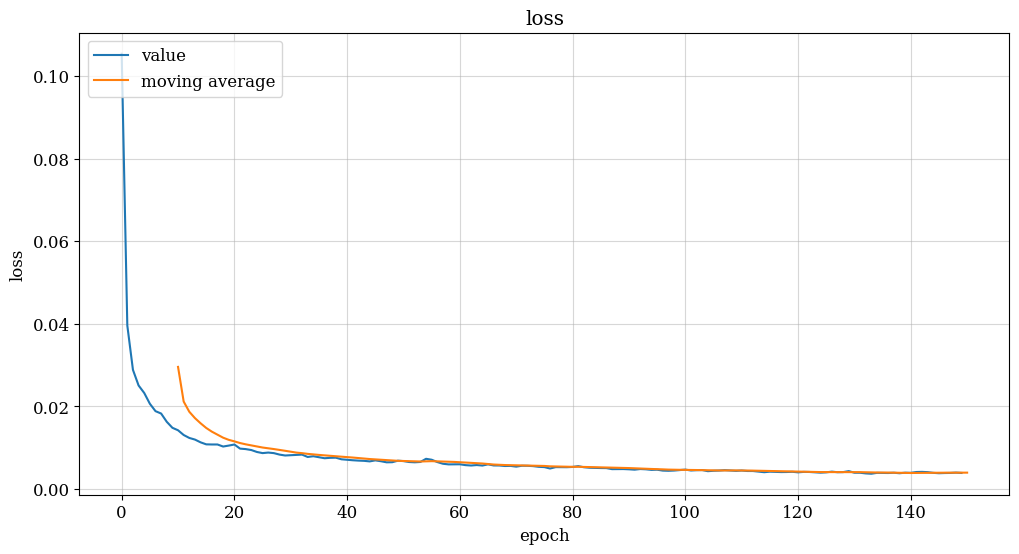

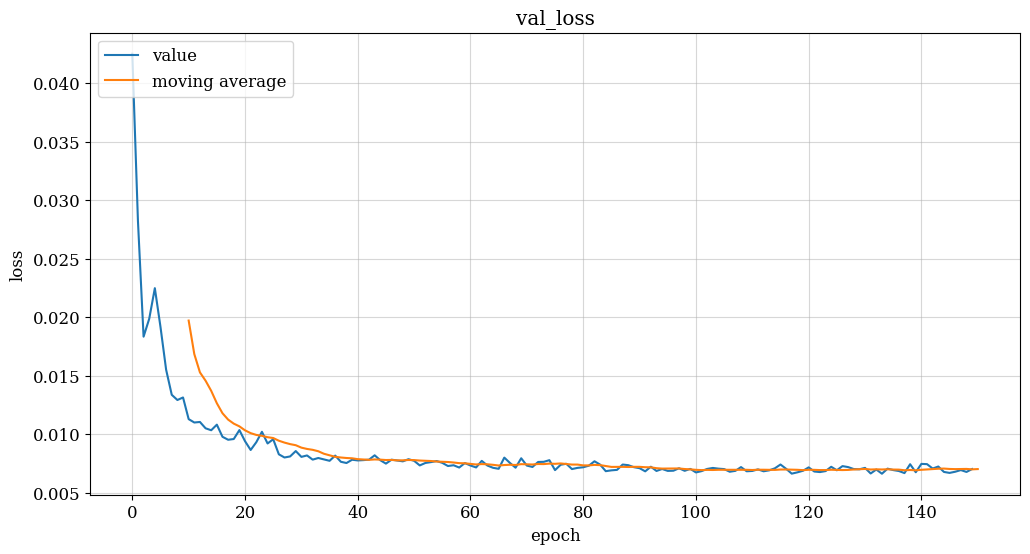

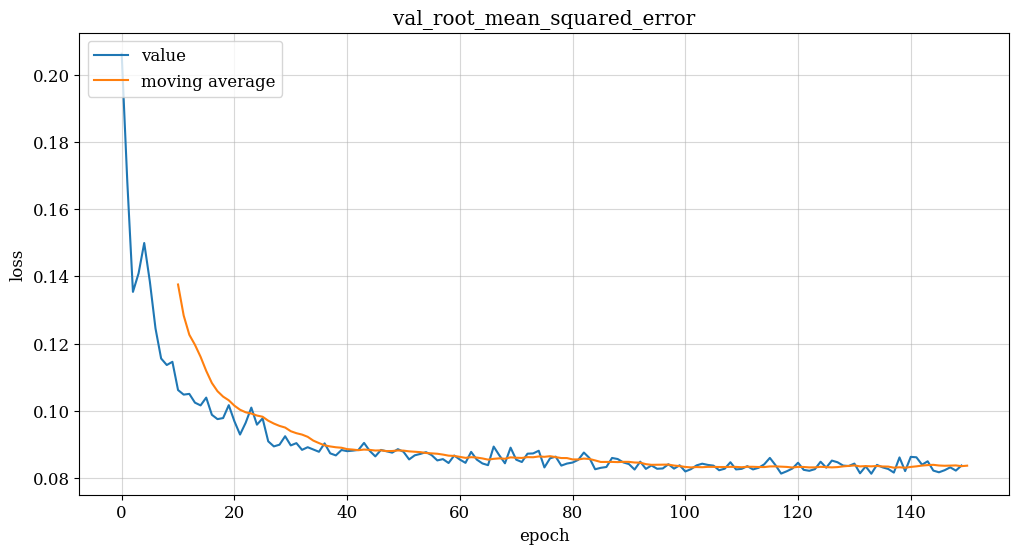

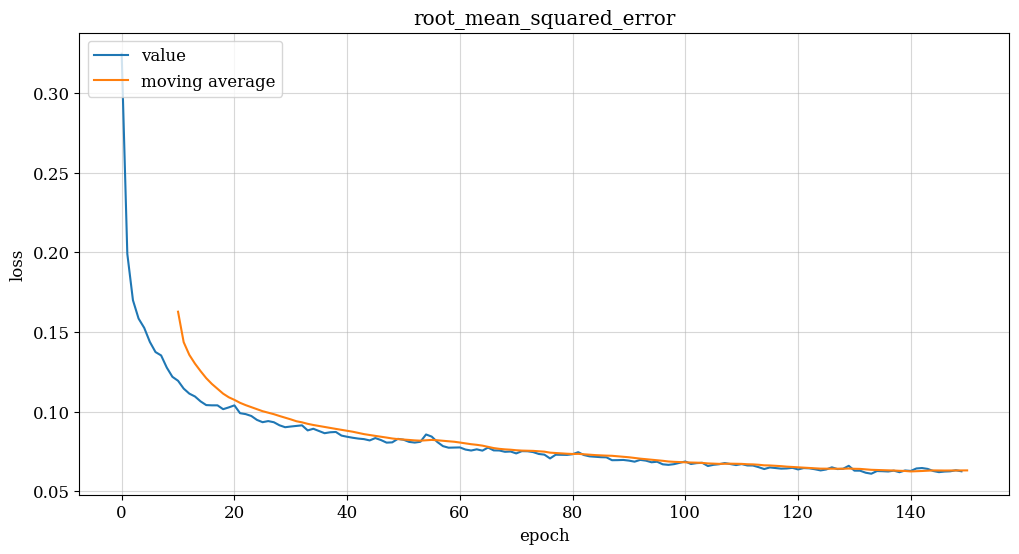

In [ ]:
WIDTH = 10
plot_training(history,'loss',WIDTH)
plot_training(history,'val_loss',WIDTH)
plot_training(history,'val_root_mean_squared_error',WIDTH)
plot_training(history,'root_mean_squared_error',WIDTH)

Prediction

In [ ]:
def predict_and_calc_score(X, Y):
    pred = model.predict(X)
    window_size = 12
    moving_average = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=0, arr=Y)
    moving_average = np.concatenate((np.zeros((1, Y.shape[1])), moving_average), axis=0)[:Y.shape[0]]
    pred_scaled = scaler_Y.inverse_transform(pred)
    moving_average_scaled = scaler_Y.inverse_transform(moving_average)
    Y_scaled = scaler_Y.inverse_transform(Y)
    baseline_RMSE = np.sqrt(np.mean((Y_scaled - moving_average_scaled) ** 2))
    model_RMSE = np.sqrt(np.mean((Y_scaled - pred_scaled) ** 2))

    return Y_scaled, pred_scaled, moving_average_scaled, model_RMSE, baseline_RMSE

def plot_prediction(actual, prediction, moving_average):
    plt.plot(actual, label="True value", linestyle='-', linewidth=1, marker='s', markersize=1)

    plt.plot(moving_average, label="Moving Average", linestyle='--', linewidth=1, marker='s', markersize=1)

    plt.plot(prediction, label="Prediction", linestyle='--', linewidth=1, marker='o', markersize=1)

    plt.title('Prediction vs. True Value', fontsize=16)
    plt.xlabel('Hour Timesteps')
    plt.ylabel('Output Value')

    plt.legend(loc='upper left', fontsize=12)
    plt.show()

In [ ]:
train_actual, train_prediction, train_moving_average, train_RMSE, baseline_RMSE = \
    predict_and_calc_score(train_X, train_Y)

print("Train Moving Average RMSE:", baseline_RMSE)
print("Train Prediction RMSE:", train_RMSE)

corr, pval = stats.spearmanr(train_actual, train_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = stats.spearmanr(train_actual, train_prediction)
pred_spearman_corr = np.mean(corr)

print("Train Moving Average Spearman Correlation:", mov_spearman_corr)
print("Train Prediction Spearman Correlation:", pred_spearman_corr)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step
Train Moving Average RMSE: 0.02154739088575425
Train Prediction RMSE: 0.011811773573535137
Train Moving Average Spearman Correlation: 0.7335293680757877
Train Prediction Spearman Correlation: 0.8109095840892637


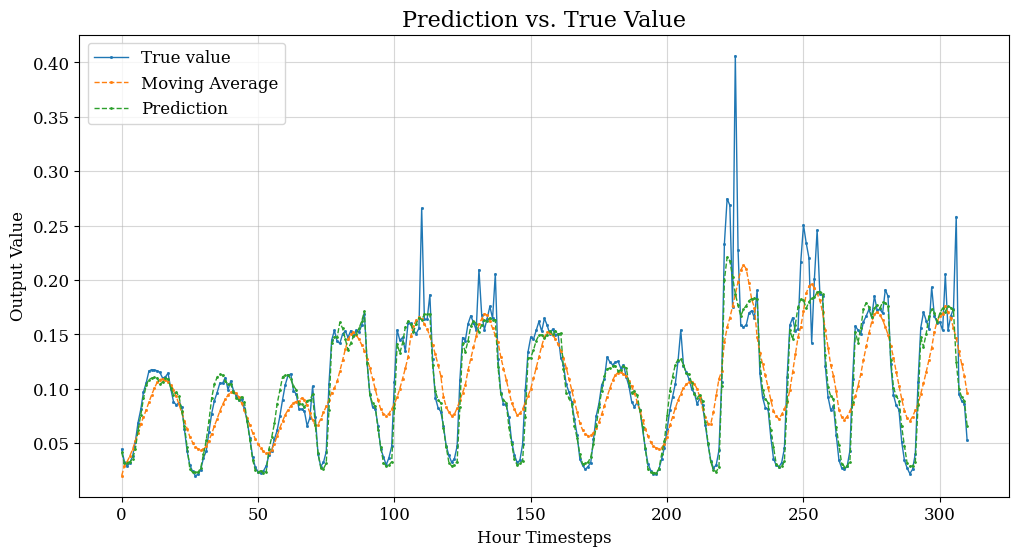

In [ ]:
location = 3
plot_prediction(train_actual[:,location], train_prediction[:,location], train_moving_average[:,location])

In [ ]:
test_actual, test_prediction, test_moving_average, test_RMSE, baseline_RMSE = \
    predict_and_calc_score(test_X, test_Y)

print("Test Moving Average RMSE:", baseline_RMSE)
print("Test Prediction RMSE:", test_RMSE)

corr, pval = stats.spearmanr(test_actual, test_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = stats.spearmanr(test_actual, test_prediction)
pred_spearman_corr = np.mean(corr)

print("Test Moving Average Spearman Correlation:", mov_spearman_corr)
print("Test Prediction Spearman Correlation:", pred_spearman_corr)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 630ms/step
Test Moving Average RMSE: 0.020397067423846615
Test Prediction RMSE: 0.018162005085374796
Test Moving Average Spearman Correlation: 0.8338943762785297
Test Prediction Spearman Correlation: 0.8816352037977102


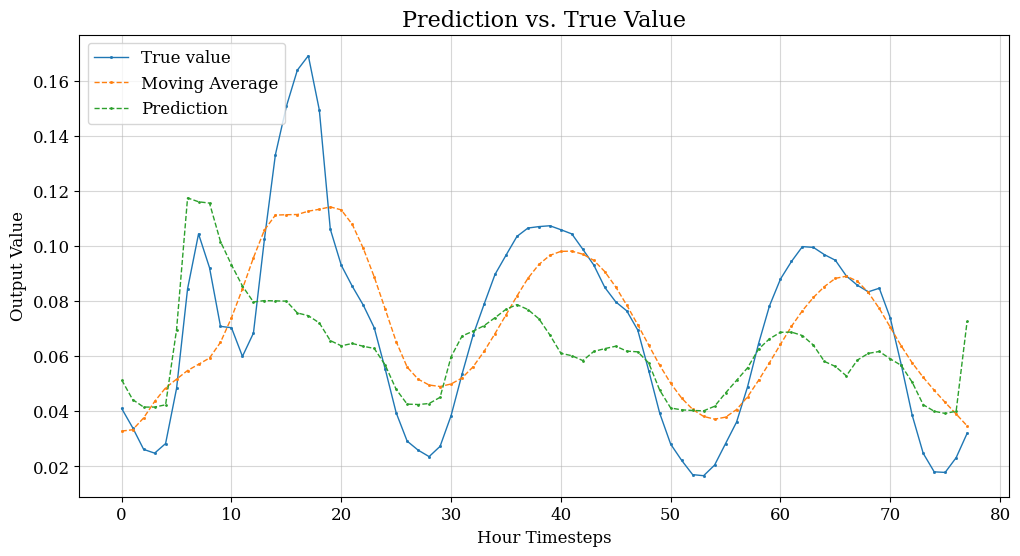

In [ ]:
location = 10
plot_prediction(test_actual[:,location], test_prediction[:,location], test_moving_average[:,location])

In [ ]:
model.save('LSTM_model')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=LSTM_model.